Train a DL model to predict whether the BTC price will go up or down from open to close each day. 

Then create a trading simulator to see how much money we can make.

# LSTM Model

## Data Pre-processing

### Get Data

In [1]:
import yfinance as yf
msft = yf.Ticker("BTC-USD")
btc_usd_hist = msft.history(period="max")

In [2]:
dataset = btc_usd_hist[['Open','High','Low','Close','Volume']]

In [3]:
data = dataset.values # get np array version

In [4]:
data.shape

(2050, 5)

### Scaling Data

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
sc = MinMaxScaler(feature_range=(0,1))
# data_scaled = sc.fit_transform(data)

### Create inputs and outputs

In [7]:
import numpy as np

In [8]:
wl = 256

In [9]:
X = np.array([sc.fit_transform(data[i-wl:i, :]) for i in range(wl, len(data))])

In [10]:
y = []
for i in range(wl, len(data)):
    diff = data[i, 3] - data[i, 0]  # close - open
    y.append(1 if diff > 0 else 0)
y = np.array(y)

In [11]:
print('Days increased:', sum(y))
print('Days Decreased:', len(y) - sum(y))

Days increased: 986
Days Decreased: 808


In [12]:
X.shape, y.shape

((1794, 256, 5), (1794,))

For the trading simulator we want the full information of the next day, not just whether it went up or down.

In [13]:
y_full = np.array([data[i, :] for i in range(wl, len(data))])

### Split Data

Get training and testing dataset for model development and hold-out dataset for trading simlation at end

In [14]:
len_holdout=100

In [15]:
X_train_and_test, X_holdout = X[:-len_holdout], X[-len_holdout:]
y_train_and_test, y_holdout = y[:-len_holdout], y_full[-len_holdout:]

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_train_and_test, y_train_and_test, test_size=0.25, random_state=0)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1270, 256, 5), (424, 256, 5), (1270,), (424,))

In [19]:
y_train.shape

(1270,)

## Model Building

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM, BatchNormalization

In [21]:
from tensorflow.keras import metrics
from tensorflow.keras import initializers

In [22]:
def build_lstm_model(data, dropout=0.0):
    model = Sequential()
    # layer 
    model.add(LSTM(units=256, return_sequences=True, input_shape=(data.shape[1], data.shape[2])))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    # layer 
    model.add(LSTM(units=256, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    # layer 
    model.add(LSTM(units=32))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    # ouput layer
    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [23]:
pos = sum(y_train)
neg = len(y_train) - sum(y_train)
total = len(y_train)

In [24]:
initial_bias = np.log(pos/neg)
initial_bias  # bias_initializer = initializers.Constant(value=initial_bias)) for Dense

0.25971783907728546

In [25]:
model = build_lstm_model(X_train)

In [26]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.15
Weight for class 1: 0.89


## Model Training

In [27]:
history = model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=True, class_weight=class_weight)

Train on 1270 samples
Epoch 1/50
1270/1270 [==============================] - 8s 6ms/sample - loss: 0.8035 - accuracy: 0.4961
Epoch 2/50
1270/1270 [==============================] - 1s 617us/sample - loss: 0.7187 - accuracy: 0.4976
Epoch 3/50
1270/1270 [==============================] - 1s 617us/sample - loss: 0.6944 - accuracy: 0.5457
Epoch 4/50
1270/1270 [==============================] - 1s 617us/sample - loss: 0.6904 - accuracy: 0.5362
Epoch 5/50
1270/1270 [==============================] - 1s 612us/sample - loss: 0.6926 - accuracy: 0.5165
Epoch 6/50
1270/1270 [==============================] - 1s 616us/sample - loss: 0.6932 - accuracy: 0.5386
Epoch 7/50
1270/1270 [==============================] - 1s 611us/sample - loss: 0.6859 - accuracy: 0.5528
Epoch 8/50
1270/1270 [==============================] - 1s 614us/sample - loss: 0.6853 - accuracy: 0.5551
Epoch 9/50
1270/1270 [==============================] - 1s 614us/sample - loss: 0.6857 - accuracy: 0.5512
Epoch 10/50
1270/1270 [===

In [28]:
train_acc = model.evaluate(X_train, y_train, verbose=False)[1]
print('Training Accuracy:', train_acc)

Training Accuracy: 0.5385827


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

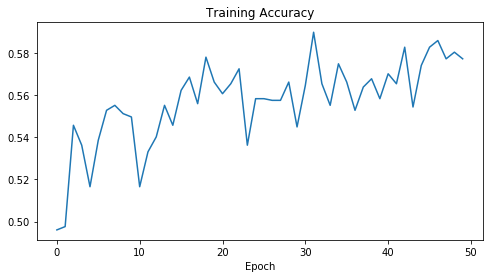

In [30]:
fig = plt.figure(figsize=[8, 4])
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.show()

## Model Testing

In [31]:
test_acc = model.evaluate(X_test, y_test, verbose=False)[1]
print('Testing Accuracy:', test_acc)

Testing Accuracy: 0.509434


In [32]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

In [34]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'TP: {tp} \t FP: {fp} ')
print(f'FN: {tn} \t\t TN: {tn} ')

TP: 134 	 FP: 122 
FN: 82 		 TN: 82 


In [35]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.49      0.40      0.44       204
           1       0.52      0.61      0.56       220

    accuracy                           0.51       424
   macro avg       0.51      0.51      0.50       424
weighted avg       0.51      0.51      0.50       424



BOOM! TIME TO MAKE SOME MONEY

# Trading Time

In [37]:
X_holdout.shape, y_holdout.shape

((100, 256, 5), (100, 5))

Let's see how much money we would have made if we did this over the last 100 days:

In [45]:
money = 1000
output = []
long, short = 0, 0
for day, data in enumerate(zip(X_holdout, y_holdout)):
    history, _open, close = data[0], data[1][0], data[1][3]
    pred = model.predict(np.reshape(history, (1, history.shape[0], history.shape[1])))
    if pred > 0.5:
        long += 1
        money = close/_open * money
    else:
        short += 1
        money = _open/close * money
    output.append(money)

In [47]:
long, short

(9, 91)

In [51]:
profit = (money - 1000)/10
print(f'Profit: {round(profit)}%')

Profit: 106.0%


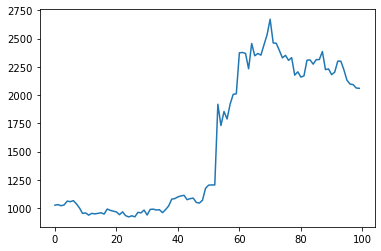

In [48]:
plt.plot(output)
plt.title(Money over time)
plt.xlabel('Days')
plt.ylabel('USD')

Let's show the BTC price over this time period for comparison

In [42]:
price = y_holdout[:,3]

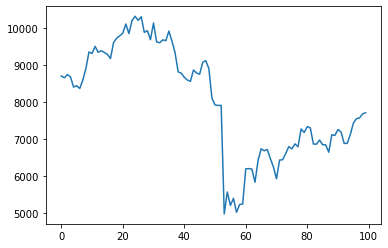

In [43]:
plt.plot(price)